In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy.sql import text
import seaborn as sns
from lib import Output, GREEN, YELLOW, TABLES, SEPARATOR, DR, getDF

O = Output('output/chart_output.txt') 
    
O.clear()
O.out(SEPARATOR)
O.out('Priliminary Viz (charts)')
O.out(SEPARATOR)

DR.setTable(year=2023, taxi_type=GREEN)
table_name = DR.getTableName()


In [ ]:
# playground

In [2]:
sql = text(f'''
SELECT pu_location_id, do_location_id, f_trip_distance, f_passenger_count, f_total_amount, f_fare_amount, 
    (unixepoch(dropoff_datetime)-unixepoch(pickup_datetime)) as trip_duration
           FROM {table_name}
WHERE f_trip_distance > 0 AND f_trip_distance < 20 
    AND f_passenger_count > 0 
    AND f_total_amount > 0 AND f_total_amount <= 100
    AND f_fare_amount > 0
    AND trip_duration <= 7200
''')

df = getDF(sql)

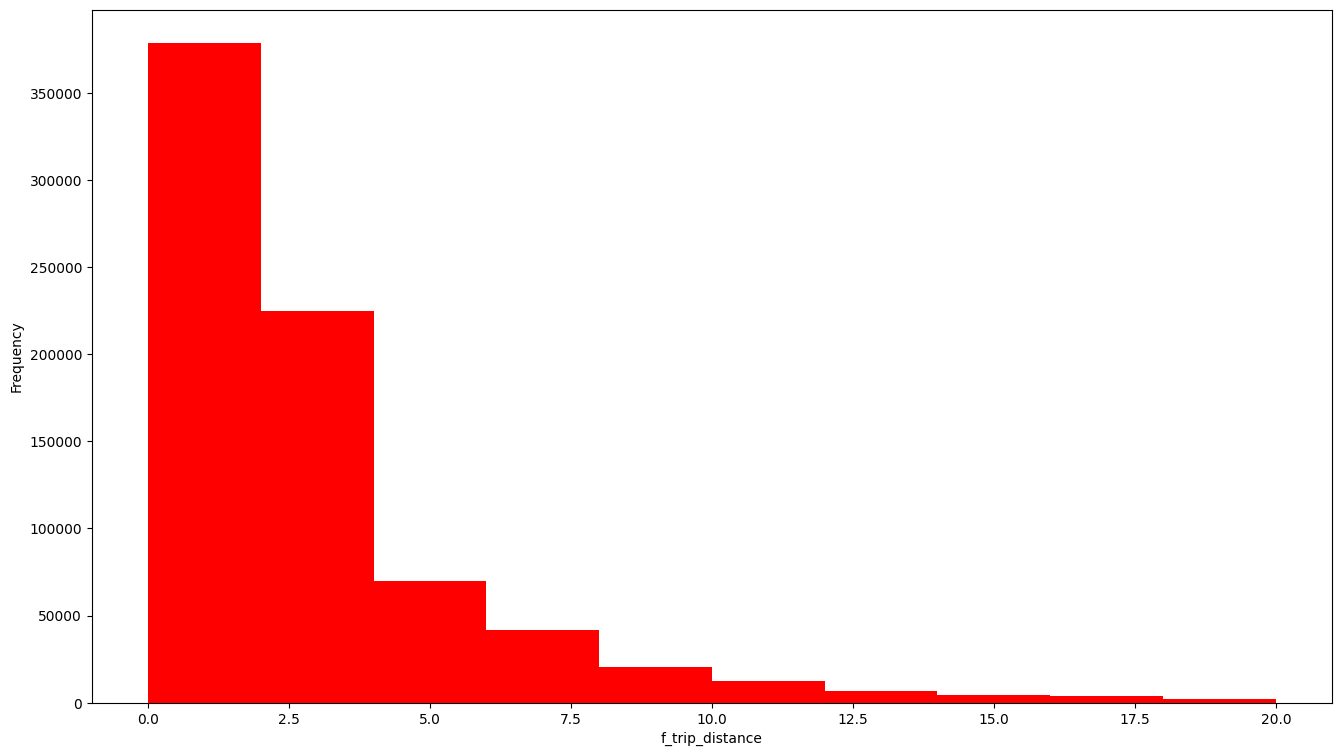

column: f_trip_distance, min: 0.01, max: 19.99


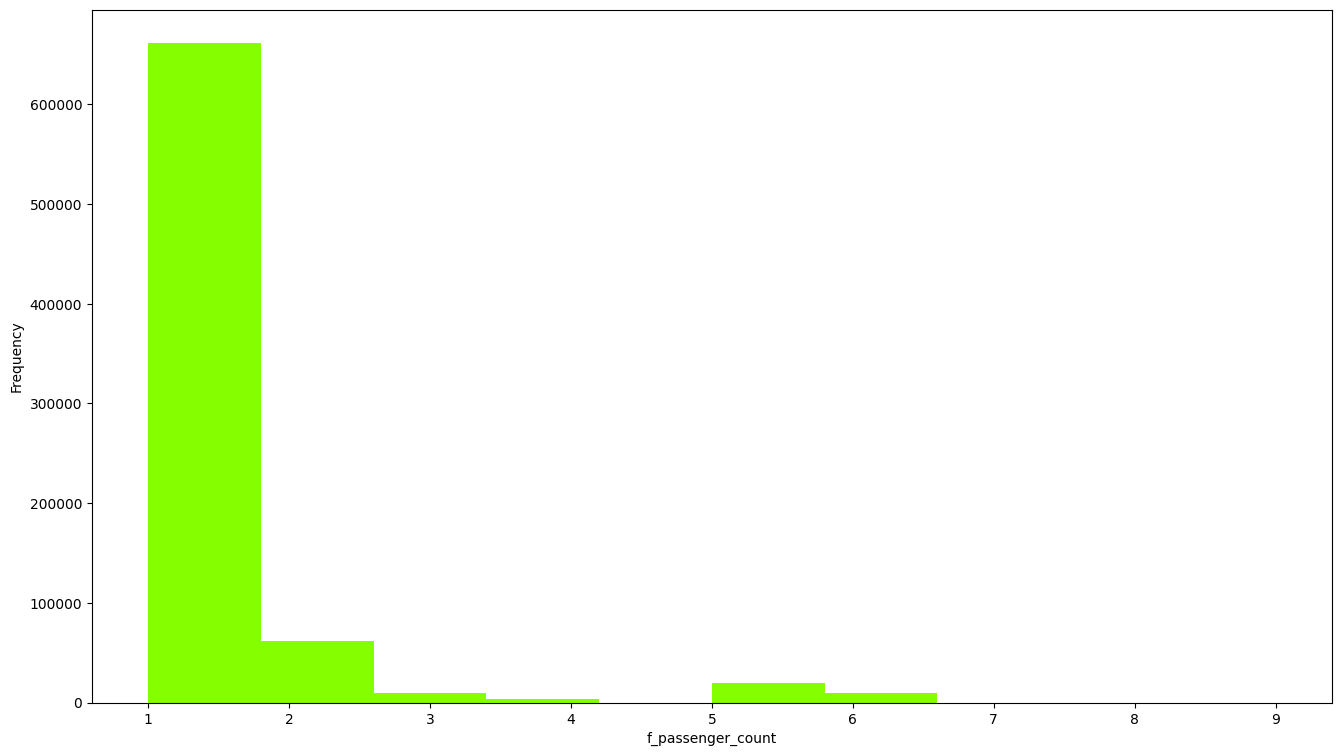

column: f_passenger_count, min: 1, max: 9


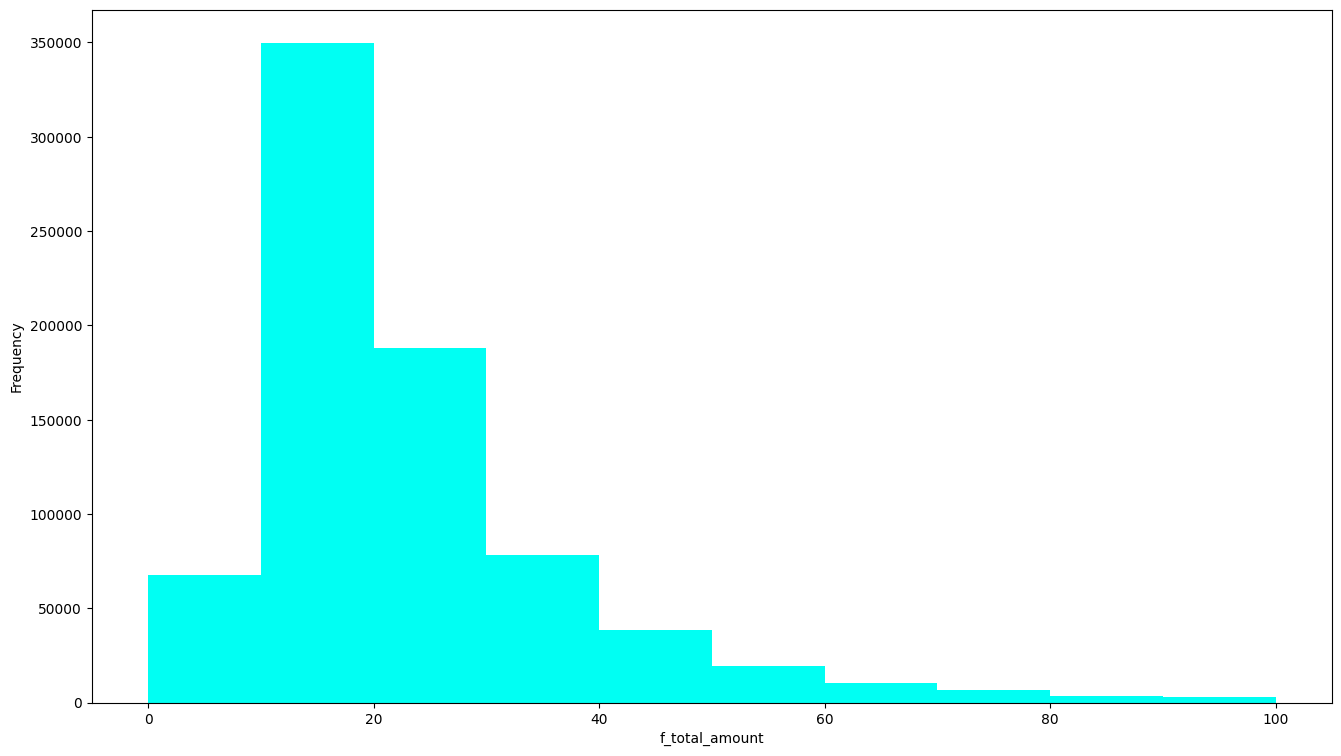

column: f_total_amount, min: 0.01, max: 100.0


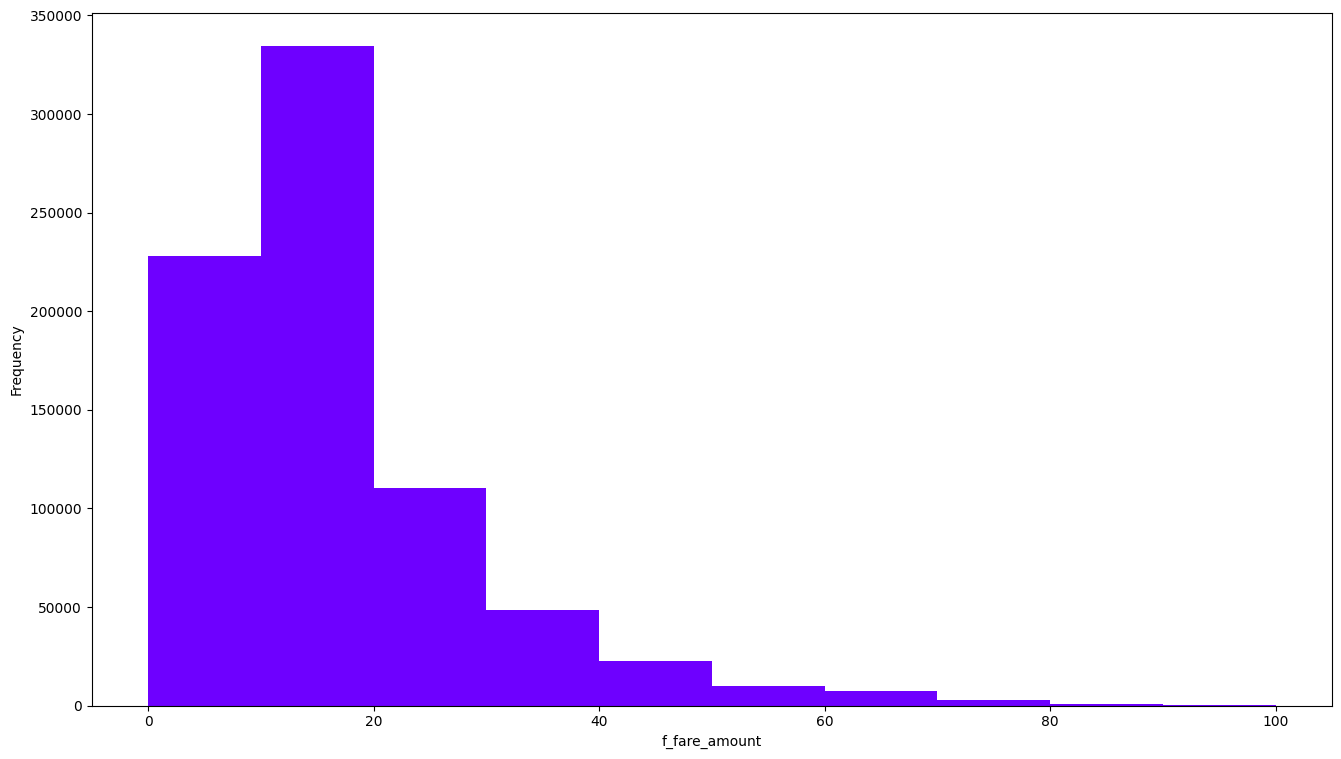

column: f_fare_amount, min: 0.01, max: 100.0


In [3]:
# histograms

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

columns = ['f_trip_distance', 'f_passenger_count', 'f_total_amount', 'f_fare_amount']
cmap = get_cmap(len(columns) + 1)

for i, c in enumerate(columns):
    plt.figure(figsize=(16,9))
    plt.hist(df[c], bins=10, range=(df[c].min(), df[c].max()), color=cmap(i))
    plt.xlabel(c)
    plt.ylabel('Frequency')
    plt.show()

    print(f'column: {c}, min: {df[c].min()}, max: {df[c].max()}')

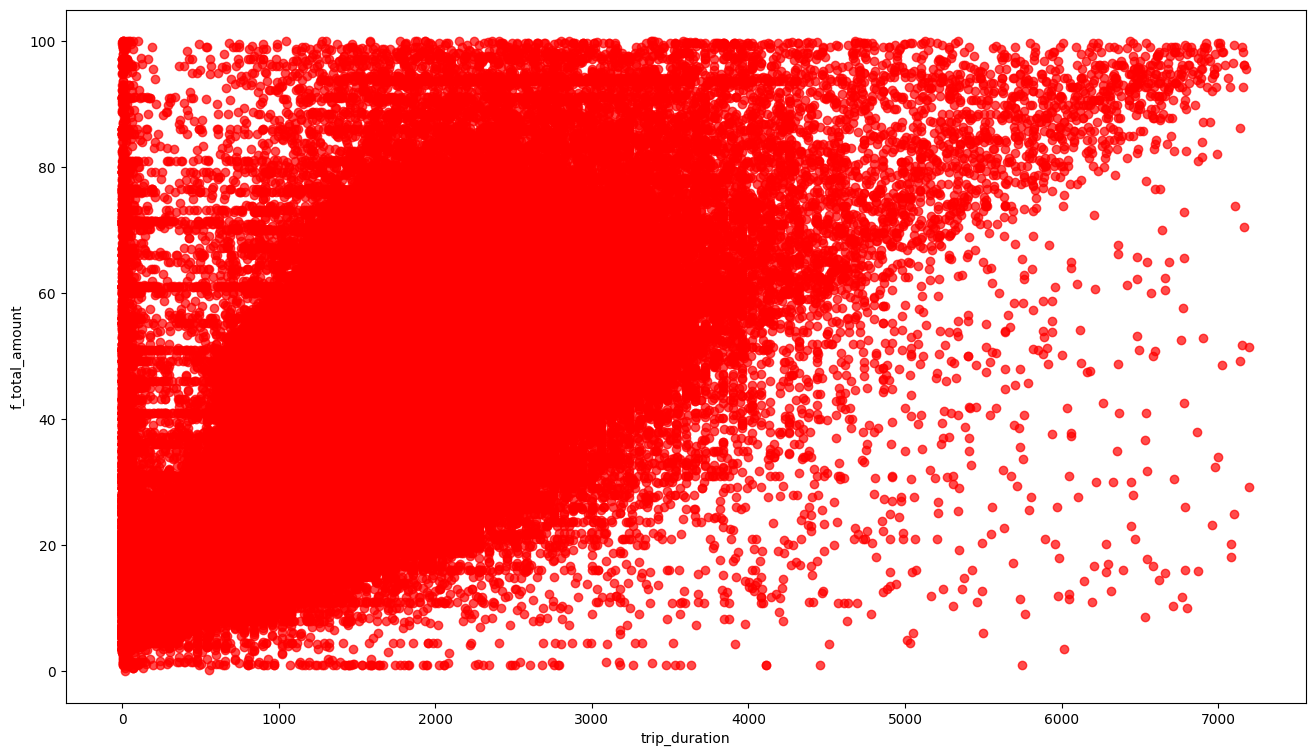

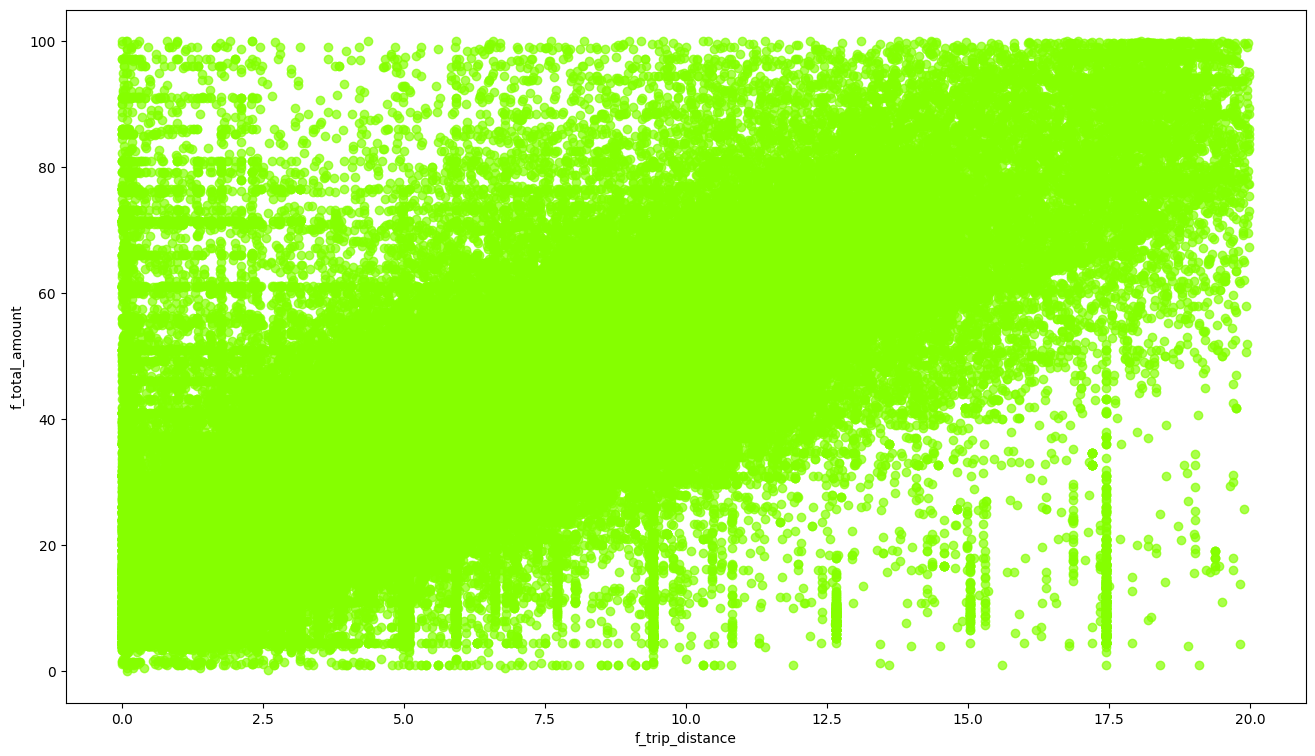

In [4]:
# scatter plots

columns = [
    ('trip_duration', 'f_total_amount'), 
    ('f_trip_distance', 'f_total_amount'), 
    ]
for i, ctuple in enumerate(columns):
    plt.figure(figsize=(16,9))
    xc, yc = ctuple
    plt.scatter(df[xc], df[yc], color=cmap(i), alpha=0.7)
    plt.xlabel(xc)
    plt.ylabel(yc)
    plt.show()


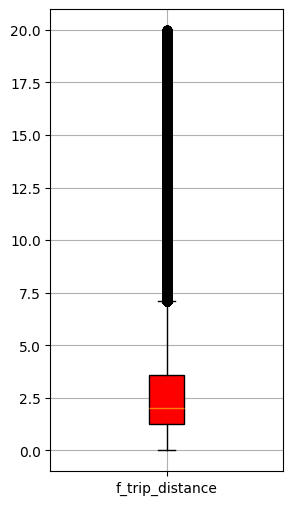

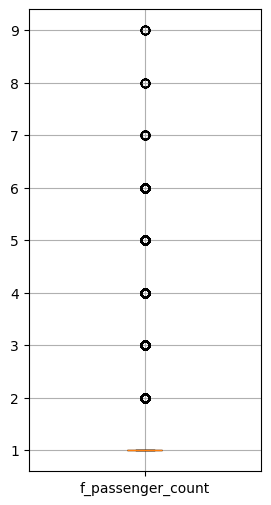

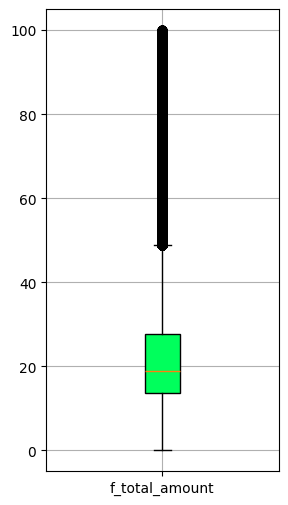

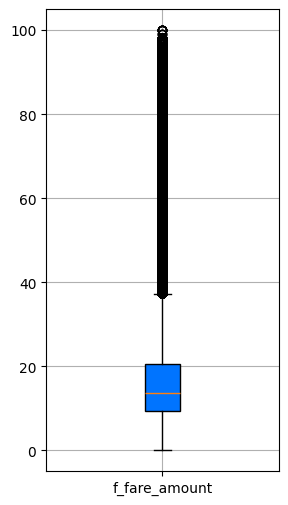

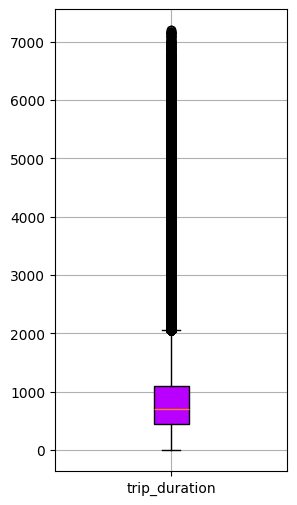

In [5]:
# box plots 
columns = ['f_trip_distance', 'f_passenger_count', 'f_total_amount', 'f_fare_amount', 'trip_duration']
cmap = get_cmap(len(columns) + 1)

box_plot_data = []
for i, c in enumerate(columns):

    plt.figure(figsize=(3,6))
    box_plot = plt.boxplot(df[c], patch_artist=True, labels=[c])

    for patch in box_plot['boxes']:
        patch.set_facecolor(cmap(i))

    plt.grid()
    plt.show()


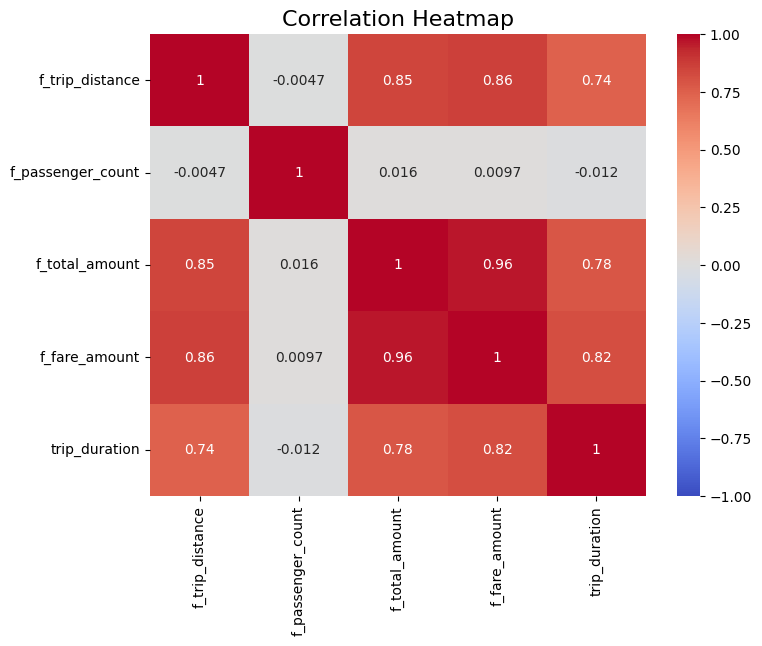

In [6]:
columns = ['f_trip_distance', 'f_passenger_count', 'f_total_amount', 'f_fare_amount', 'trip_duration']

# correlation matrix - green vs yellow
corr_matrix = df[columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Add titles and labels
plt.title('Correlation Heatmap', fontsize=16)
plt.show()


In [7]:
# downsample data by every hour for every day
year = 2023
sql = text(f'''
    WITH t AS (
        SELECT *, 
            (unixepoch(dropoff_datetime)-unixepoch(pickup_datetime)) as trip_duration,
            CAST(strftime('%Y', pickup_datetime) as integer) as year
        FROM {table_name}
        WHERE f_trip_distance > 0 AND f_trip_distance < 20 
            AND f_passenger_count > 0 
            AND f_total_amount > 0 AND f_total_amount <= 100
            AND f_fare_amount > 0
            AND trip_duration <= 7200
            AND year = {year}
    )
    SELECT (strftime('%Y-%m-%d %H', pickup_datetime)) as dt_hr, 
           AVG(f_total_amount) as total_amount, 
           AVG(f_fare_amount) as fare_amount, 
           AVG(f_trip_distance) as trip_distance,
           AVG(trip_duration) as trip_duration
    FROM t
    GROUP BY dt_hr
''')

df = getDF(sql)
O.out(df, True, 100)


In [8]:
# downsample data by every day
year = 2023
sql = text(f'''
    WITH t AS (
        SELECT *, 
            (unixepoch(dropoff_datetime)-unixepoch(pickup_datetime)) as trip_duration,
            CAST(strftime('%Y', pickup_datetime) as integer) as year
        FROM {table_name}
        WHERE f_trip_distance > 0 AND f_trip_distance < 20 
            AND f_passenger_count > 0 
            AND f_total_amount > 0 AND f_total_amount <= 100
            AND f_fare_amount > 0
            AND trip_duration <= 7200
            AND year = {year}
    )
    SELECT (strftime('%Y-%m-%d', pickup_datetime)) as dt_dy, 
           AVG(f_total_amount) as total_amount, 
           AVG(f_fare_amount) as fare_amount, 
           AVG(f_trip_distance) as trip_distance,
           AVG(trip_duration) as trip_duration
    FROM t
    GROUP BY dt_dy
''')

df = getDF(sql)
O.out(df, True, 100)


In [9]:
df['dt_dy'] = pd.to_datetime(df['dt_dy'])

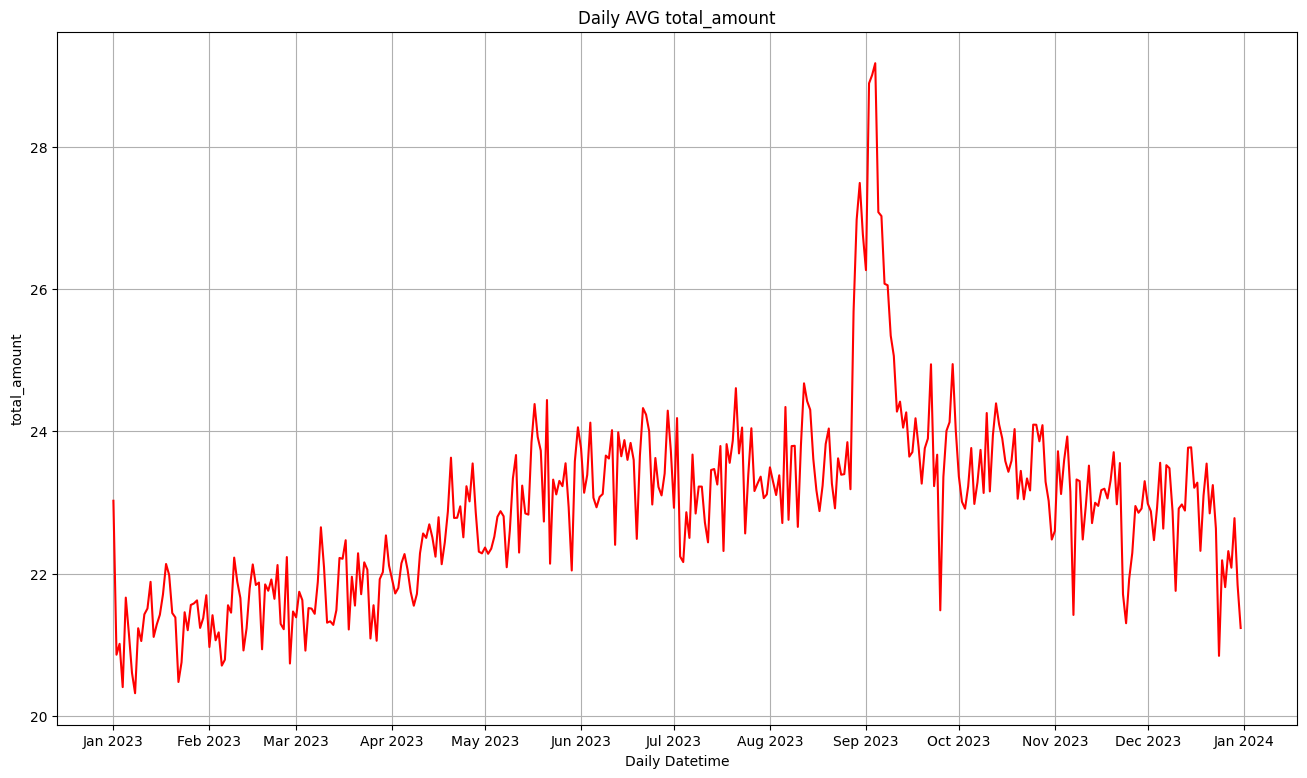

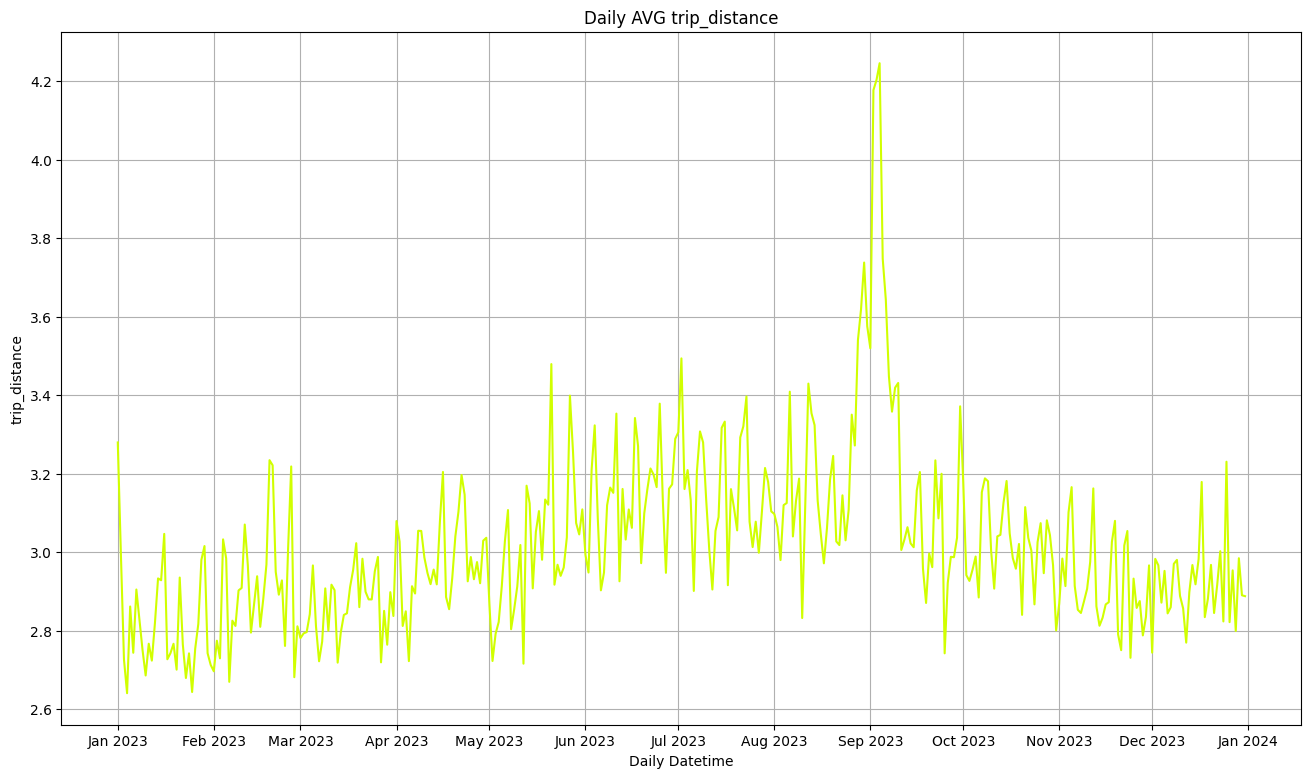

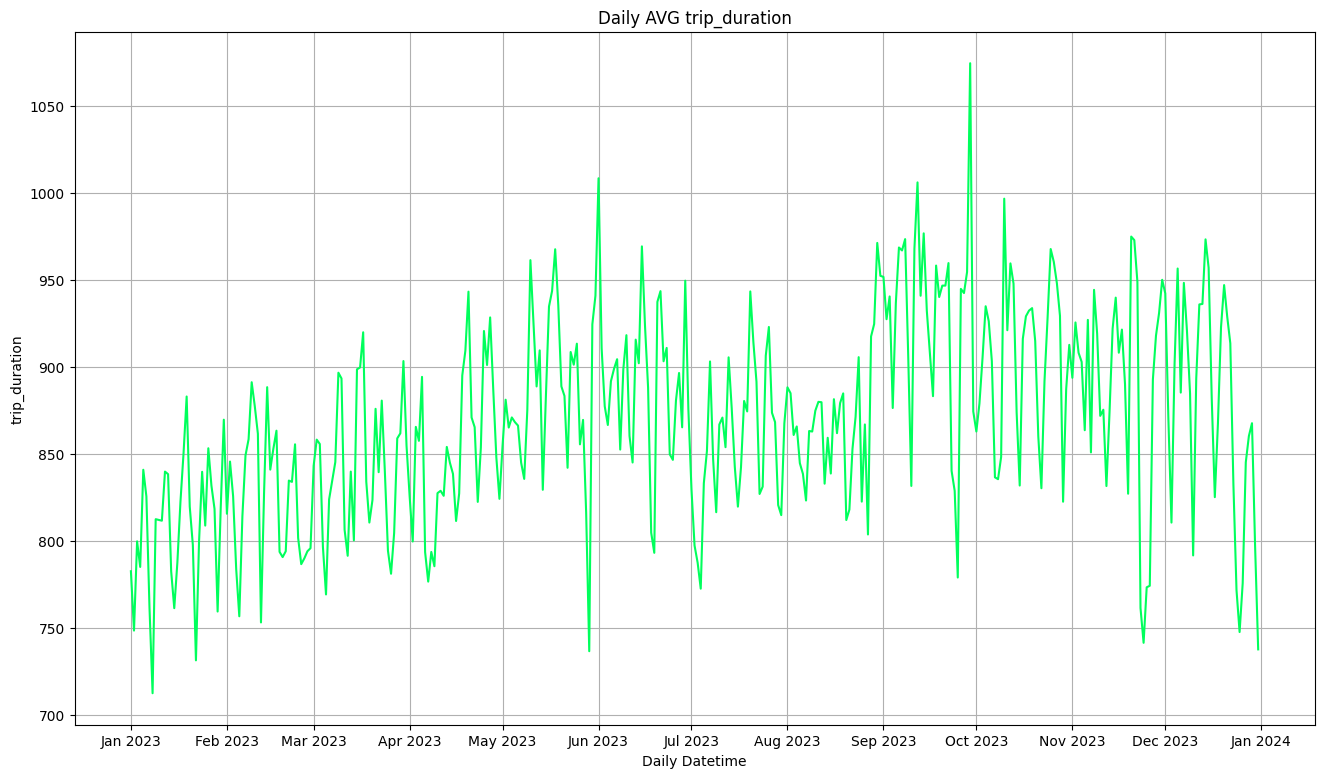

In [10]:
import matplotlib.dates as mdates



# compare time distribution of variables like passengers, amount and distance of green taxi vs yellow taxi
columns = [
    'total_amount', 
    # 'fare_amount', 
    'trip_distance',
    'trip_duration'
]
for i, c in enumerate(columns):
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(9)
    ax.plot(df['dt_dy'], df[c], color=cmap(i))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.xlabel('Daily Datetime')
    plt.ylabel(c)
    plt.grid(True)
    plt.title(f'Daily AVG {c}')
    plt.show()